In [167]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import utils.minimization as minim

In [168]:
# Reloading modules
importlib.reload(minim)

<module 'utils.minimization' from 'D:\\Steurendo\\Programmazione\\Python\\PyCharm\\ICT4Health\\utils\\minimization.py'>

In [169]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns
print(features)

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')


In [170]:
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')

Dataset size = (5875, 22)
Dataset features count = 22


<Axes: ylabel='Frequency'>

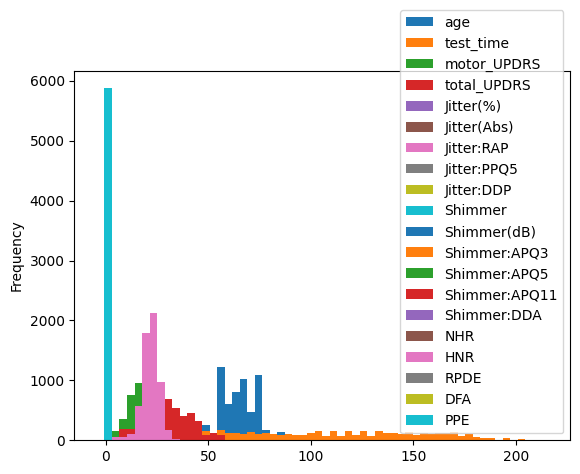

In [171]:
# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(bins=60)

In [172]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()

    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along (0, 1) -> (x, y) axis
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


In [173]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

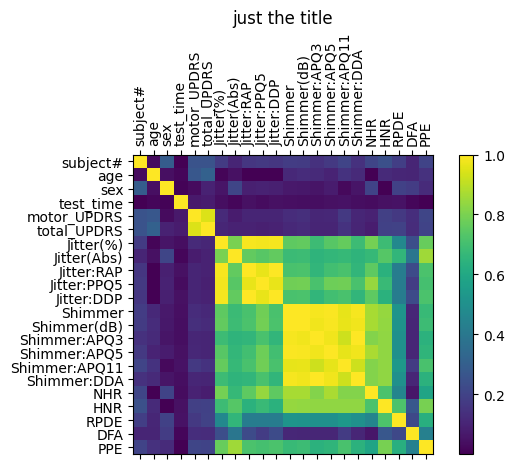

In [174]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

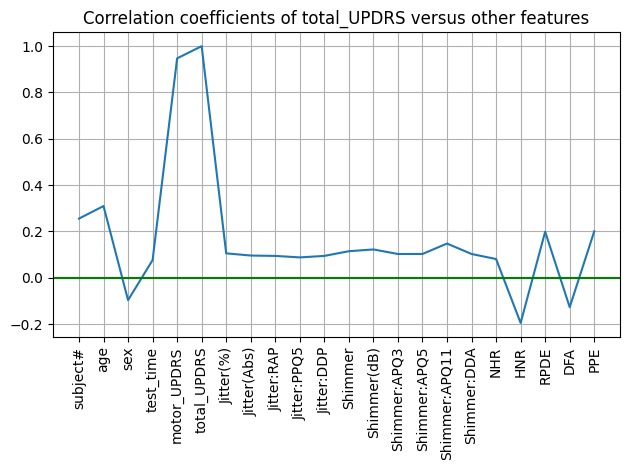

In [175]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

In [176]:
seed = 319244
drop_motor_UPDRS = False

In [177]:
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)

In [178]:
Ntr = int(Np * 0.5)  # Number of training points
Nte = Np - Ntr  # Number of test points
X_tr = Xsh[:Ntr]
mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [179]:
Xsh_norm = (Xsh - mm_vals) / ss_vals
ysh_norm = Xsh_norm['total_UPDRS']
Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#', 'Jitter:DDP', 'Shimmer:DDA'], axis=1)
# Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#'], axis=1)
if drop_motor_UPDRS:
    Xsh_norm = Xsh_norm.drop(['motor_UPDRS'], axis=1)

X_tr_norm = Xsh_norm[:Ntr]
X_te_norm = Xsh_norm[Ntr:]
y_tr_norm = ysh_norm[:Ntr]
y_te_norm = ysh_norm[Ntr:]

In [197]:
solver = minim.SolverSteepestDescent(X_tr_norm, y_tr_norm)
solver.solve(minim.StoppingCondition.absolute_improvement, cond_eps=1e-5)
w_hat = solver.result
# w_hat = np.linalg.pinv(X_tr_norm) @ y_tr_norm

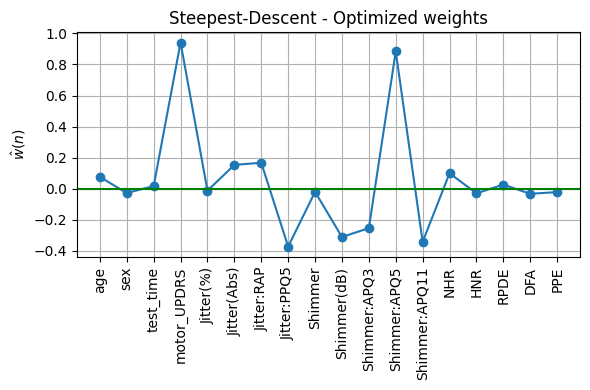

In [198]:
regressors = X_tr_norm
Nf = len(w_hat)
nn = np.arange(Nf)
plt.figure(figsize=(6, 4))
plt.plot(nn, w_hat, '-o')
ticks = nn
plt.xticks(ticks, regressors, rotation=90)
plt.axhline(y=0, color='g')
plt.ylabel(r'$\^w(n)$')
plt.title('Steepest-Descent - Optimized weights')
plt.grid()
plt.tight_layout()
plt.savefig('./SD-w_hat.png')
plt.show()

Now collinearity is avoided by dropping the features "Jitter:DDP" and "Shimmer:DDA", so the weight coefficients are normalized.

In [199]:
y_hat_te_norm = X_te_norm @ w_hat
y_hat_tr_norm = X_tr_norm @ w_hat

In [200]:
# De-normalization
y_hat_tr = y_hat_tr_norm * sy + my
y_tr = y_tr_norm * sy + my
y_hat_te = y_hat_te_norm * sy + my
y_te = y_te_norm * sy + my

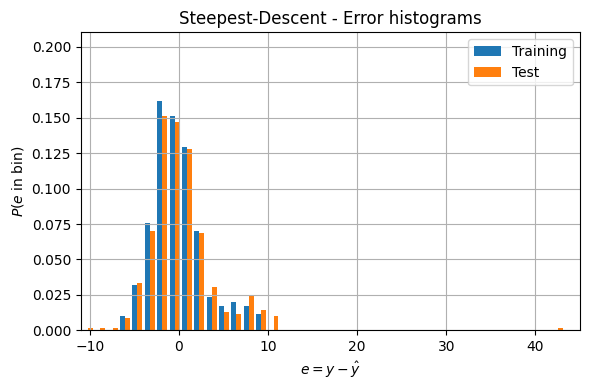

In [201]:
E_tr = y_tr - y_hat_tr
E_te = y_te - y_hat_te
e = [E_tr, E_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Training', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.grid()
plt.ylim([0, 0.21])
plt.xlim([-11, 45])
plt.title('Steepest-Descent - Error histograms')
plt.tight_layout()
plt.savefig('./SD-Error-hist.png')
plt.show()

TODO: comment

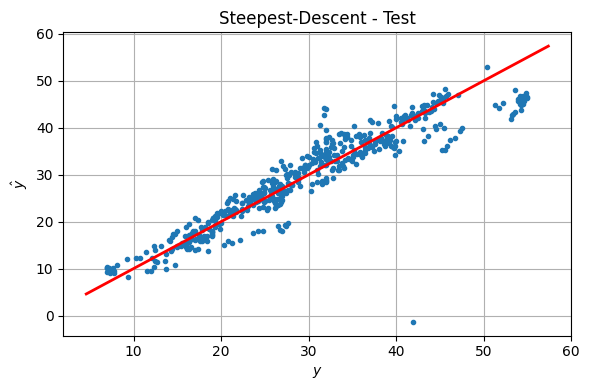

In [202]:
y_hat_te = (X_te_norm @ w_hat) * sy + my
y_te = y_te_norm * sy + my
plt.figure(figsize=(6, 4))
plt.plot(y_te, y_hat_te, '.')
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.grid()
plt.title('Steepest-Descent - Test')
plt.tight_layout()
plt.savefig('./SD-yhat_vs_y.png')
plt.show()

In [203]:
E_tr_min = E_tr.min()
E_tr_max = E_tr.max()
E_tr_mu = E_tr.mean()
E_tr_sig = E_tr.std()
E_tr_MSE = np.mean(E_tr ** 2)
R2_tr = 1 - E_tr_MSE / np.var(y_tr)
c_tr = np.mean((y_tr - y_tr.mean()) * (y_hat_tr - y_hat_tr.mean())) / (y_tr.std() * y_hat_tr.std())
E_te_min = E_te.min()
E_te_max = E_te.max()
E_te_mu = E_te.mean()
E_te_sig = E_te.std()
E_te_MSE = np.mean(E_te ** 2)
R2_te = 1 - E_te_MSE / np.var(y_te)
c_te = np.mean((y_te - y_te.mean()) * (y_hat_te - y_hat_te.mean())) / (y_te.std() * y_hat_te.std())

In [204]:
rows = ['Training', 'Test']
cols = ['min', 'max', 'mean', 'std', 'MSE', 'R^2', 'correlation coefficient']
p = np.array([
    [E_tr_min, E_tr_max, E_tr_mu, E_tr_sig, E_tr_MSE, R2_tr, c_tr],
    [E_te_min, E_te_max, E_te_mu, E_te_sig, E_te_MSE, R2_te, c_te]
])
results = pd.DataFrame(p, columns=cols, index=rows)
print(results)

                min        max          mean       std        MSE       R^2   
Training  -6.375956   9.293961  1.668699e-15  3.021529   9.111192  0.917726  \
Test     -12.289132  43.251965  2.194033e-01  3.981327  15.867078  0.864770   

          correlation coefficient  
Training                 0.956045  
Test                     0.928314  
